In [28]:
import sqlite3

import matplotlib.ticker as ticker
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

params = {
    # "text.usetex": True,
    'axes.labelsize'  : 15.5,
    'font.family'     : 'sans-serif',
    'axes.titlesize'  : 15.5,
    'font.size'       : 14,
    'legend.fontsize' : 13,
    # 'legend.font.family'     : 'sans-serif', nope this does not work
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13}
plt.rcParams.update(params)

%matplotlib inline

PATH_TO_MASKS = 'postgres/20211004-074221_grab_cut_mask.csv'

NUMBER_OF_CELLS = {'Neuroblastoma_5': 18, 'Neuroblastoma_16': 16, 'Neuroblastoma_10': 16, 'Normal_2': 26, 'Normal_4': 15}

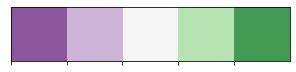

In [29]:
# kromp_cmap = sns.diverging_palette(250, 17, s=75, l=45, n=5, center="dark")
kromp_cmap = sns.color_palette("PRGn", 5)
sns.palplot(kromp_cmap)

## *RQ2*: How does providing manual constraints to the segmentation method affect the quality of the segmentation?

Quality metrics:

* IoU

In [30]:
conn = sqlite3.connect('grabcutstudy.db')
masks_df = pd.read_sql_query('''select * from maskchoiceinteractions''', conn)
conn.close()

In [31]:
masks_df.columns

Index(['interaction_uuid', 'session_id', 'image_id', 'annotated_pixels',
       'foreground_pixels', 'background_pixels', 'scribbles',
       'foreground_scribbles', 'background_scribbles', 'segmentation_attempts',
       'first_interaction_time', 'mask_creation_time', 'mask_uuid', 'mask',
       'annotated_pixels_percentage', 'interaction_duration',
       'total_submissions'],
      dtype='object')

In [32]:
def idx_str_to_np_array(x):
    indices = [int(s) for s in x.split(',')]
    mask_array = np.empty((384, 512), dtype=np.uint8).ravel()
    mask_array.fill(0)
    mask_array[indices] = 1
    return mask_array.reshape((384, 512))


masks_df['mask_arr'] = masks_df['mask'].apply(idx_str_to_np_array)
del masks_df['mask']

In [33]:
def has_id(x):
    return x in {'neurblas5', 'neurblas16', 'neurblas10', 'normal2', 'normal4'}

# kromp_masks_df = masks_df.loc[masks_df['image_id'] in kromp_ids]
masks_df = masks_df.assign(is_kromp_data=masks_df['image_id'].apply(has_id))
kromp_mask_df = masks_df[masks_df['is_kromp_data']]

In [34]:
gt = np.load('kromp_gt.npz')

neurblas5_gt = gt['neurblas5']
neurblas10_gt = gt['neurblas10']
neurblas16_gt = gt['neurblas16']
normal2_gt = gt['normal2']
normal4_gt = gt['normal4']

In [35]:
def get_iou_for_mask_row(row, gt):
    image_id = row['image_id']
    i = np.logical_and(row['mask_arr'], gt[image_id])
    u = np.logical_or(row['mask_arr'], gt[image_id])
    return np.sum(i) / np.sum(u)

# don't do this
# kromp_mask_df['iou'] = kromp_mask_df.apply(iou, gt=gt, axis=1)
kromp_mask_df = kromp_mask_df.assign(iou=kromp_mask_df.apply(get_iou_for_mask_row, gt=gt, axis=1))

In [36]:
kromp_ids = ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']
kromp_imgs = pd.api.types.CategoricalDtype(ordered=True, categories=kromp_ids)
kromp_mask_df['image_id'] = kromp_mask_df['image_id'].astype(kromp_imgs)

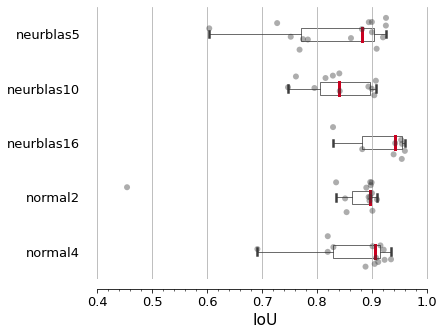

In [37]:
# sns.set_style("ticks")
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
    # 'ytick.left': False,
})

f, ax = plt.subplots(figsize=(6, 5))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#ca0020', 'linewidth': 3},
    # 'whiskerprops':{'linewidth': 2.5},
    'capprops':{'linewidth': 2.5}
}

sns.boxplot(y='image_id', x='iou', data=kromp_mask_df, showfliers = False, width=.24, linewidth=0.75, whis=1.8, **PROPS)

sns.stripplot(y='image_id', x='iou', data=kromp_mask_df, size=6, color=".2", alpha=.4, jitter=0.3)

ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator())
# ax.grid(b=True, which='minor', linewidth=0.5)
ax.set(xlabel="IoU")
ax.set(ylabel="")
ax.set_xlim([0.4, 1.01])
sns.despine(offset=10, trim=True)
# ax.spines['left'].set_visible(False)
# plt.xticks(rotation=15)

plt.savefig(f"plots/kromp_annotated_iou.png", bbox_inches='tight')
plt.show()

In [38]:
print('Median IoU of human annotators')
print(kromp_mask_df.groupby(['image_id'])['iou'].median())

Median IoU of human annotators
image_id
neurblas5     0.882201
neurblas10    0.840924
neurblas16    0.942667
normal2       0.896485
normal4       0.905332
Name: iou, dtype: float64


In [39]:
print('IoU of automatic segmentations')

computed_masks_dict = np.load('testimages_seg.npz')

def compute_mean_iou_for_predictions(predictions, groundtruth):
    i = np.logical_and(predictions, groundtruth)
    u = np.logical_or(predictions, groundtruth)
    return np.sum(i) / np.sum(u)

for id in kromp_ids:
    print(f'{id}:\t Box: {round(compute_mean_iou_for_predictions(computed_masks_dict[id][1], gt[id]), 3)}\t Adapt. thresh: {round(compute_mean_iou_for_predictions(computed_masks_dict[id][2], gt[id]), 3)}')

IoU of automatic segmentations
neurblas5:	 Box: 0.408	 Adapt. thresh: 0.796
neurblas10:	 Box: 0.428	 Adapt. thresh: 0.776
neurblas16:	 Box: 0.427	 Adapt. thresh: 0.876
normal2:	 Box: 0.539	 Adapt. thresh: 0.766
normal4:	 Box: 0.459	 Adapt. thresh: 0.877


In [40]:
import Cdf

In [41]:
neu5_ious = kromp_mask_df.loc[kromp_mask_df['image_id'] == 'neurblas5'].iou.values.tolist()
neu5_ious_cdf = Cdf.MakeCdfFromList(neu5_ious)

neu10_ious = kromp_mask_df.loc[kromp_mask_df['image_id'] == 'neurblas10'].iou.values.tolist()
neu10_ious_cdf = Cdf.MakeCdfFromList(neu10_ious)

neu16_ious = kromp_mask_df.loc[kromp_mask_df['image_id'] == 'neurblas16'].iou.values.tolist()
neu16_ious_cdf = Cdf.MakeCdfFromList(neu16_ious)

normal2_ious = kromp_mask_df.loc[kromp_mask_df['image_id'] == 'normal2'].iou.values.tolist()
normal2_ious_cdf = Cdf.MakeCdfFromList(normal2_ious)

normal4_ious = kromp_mask_df.loc[kromp_mask_df['image_id'] == 'normal4'].iou.values.tolist()
normal4_ious_cdf = Cdf.MakeCdfFromList(normal4_ious)

In [42]:
kromp_ids = ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']
ious_cdfs = [neu5_ious_cdf, neu10_ious_cdf, neu16_ious_cdf, normal2_ious_cdf, normal4_ious_cdf]

def cdf_to_concat_df(cdf, category):
    xs, ps = cdf.Render()
    category_list = [category for i in range(len(xs))]
    return pd.DataFrame.from_dict({
        'xs': xs,
        'ps': ps,
        'image_id': category_list,
    })

ious_cdfs_df = pd.concat([cdf_to_concat_df(c, d) for d, c in zip(kromp_ids, ious_cdfs)]).reset_index(drop=True)

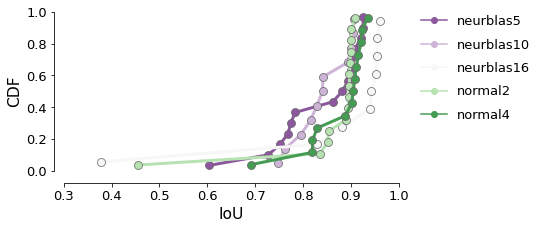

In [43]:
kromp_cmap = sns.color_palette("PRGn", 5)
# sns.palplot(kromp_cmap)

sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
    'ytick.left': True,
})

f, ax = plt.subplots(figsize=(6, 3))

marker_style={
    'markeredgecolor': 'dimgrey'
}

sns.lineplot(data=ious_cdfs_df, x='xs', y='ps',
             # palette=kromp_cmap,
             dashes=False,
             hue='image_id', style='image_id', ci=None, markers=['o', 'o', 'o', 'o', 'o'], linewidth=3, markersize=8, palette='PRGn', ax=ax, **marker_style)

# handles, labels = ax.get_legend_handles_labels()
# for ha in handles:
#     ha.set_edgecolor("dimgrey")
#
# lgd = ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labelspacing=0.8, frameon=False)

# for legend_handle in ax.get_legend().legendHandles:
#     legend_handle._legmarker.set_markeredgewidth(1)
#     legend_handle._legmarker.set_markeredgecolor('dimgrey')
#     legend_handle.set_edgecolor('dimgrey')

ax.set_xlim([0.3, 1.0])
# ax.set_ylim([-0.01, 1.01])

l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labelspacing=0.8, frameon=False)

# ax.yaxis.grid(True)
ax.set(ylabel="CDF")
ax.set(xlabel="IoU")
sns.despine(offset=10, trim=True)
# plt.xticks(rotation=15)

plt.savefig(f"plots/kromp_annotated_iou_CDF.png", bbox_inches='tight')
plt.show()

In [44]:
print(f'{neu5_ious_cdf.Prob(0.79)}')
print(f'{1 - neu16_ious_cdf.Prob(0.9)}')
print(f'{min(neu16_ious_cdf.xs)}')

0.4
0.6666666666666667
0.3776095434732737


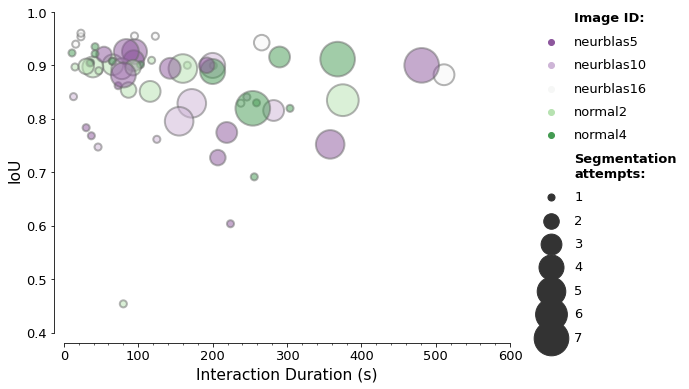

In [45]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
    'ytick.left': True,
})

f, ax2 = plt.subplots(figsize=(7, 5))

g = sns.scatterplot(x="interaction_duration", y="iou", hue="image_id", size="total_submissions",
            sizes=(50, 1200), alpha=.5, palette=kromp_cmap, edgecolor='dimgrey', linewidth=2,
            data=kromp_mask_df, ax=ax2)

ax2.set(xlabel="Interaction Duration (s)")
ax2.set(ylabel="IoU")

ax2.set_ylim([0.4, 1.01])
ax2.set_xlim([0, 600])
ax2.get_xaxis().set_minor_locator(ticker.AutoMinorLocator())

sns.despine(offset=10, trim=True)

l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labelspacing=0.8, frameon=False)

plt.setp(l.texts, family='DejaVu Sans')

t1, t2 = l.get_texts()[0], l.get_texts()[6]
t1._fontproperties = t2._fontproperties.copy()

t1.set_text('Image ID:')
# t1.set_size('14')
t1.set_weight('bold')
t2.set_text('Segmentation\nattempts:')
# t2.set_size('14')
t2.set_weight('bold')

plt.savefig(f"plots/kromp_iou_to_duration.png", bbox_inches='tight')
plt.show()

<ipython-input-46-732e61754eb8>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(new_labels)


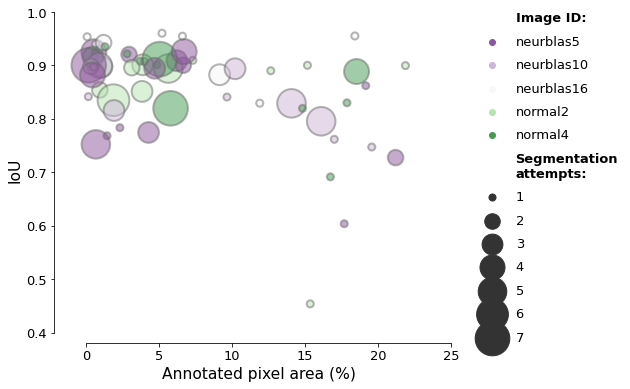

In [46]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax3 = plt.subplots(figsize=(7, 6))


g = sns.scatterplot(x="annotated_pixels_percentage", y="iou", hue="image_id", size="total_submissions",
                    sizes=(50, 1200), alpha=.5, palette=kromp_cmap, edgecolor='dimgrey', linewidth=2,
                    data=kromp_mask_df, ax=ax3)

ax3.set(xlabel="Annotated pixel area (%)")
ax3.set(ylabel="IoU")

ax3.set_ylim([0.4, 1.01])
ax3.set_xlim([-0.015, 0.252])

# ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
new_labels = [i * 5 for i in range(6)]
ax3.set_xticklabels(new_labels)
ax2.get_xaxis().set_minor_locator(ticker.AutoMinorLocator())

sns.despine(offset=10, trim=True)

l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labelspacing=0.8, frameon=False)

plt.setp(l.texts, family='DejaVu Sans')

t1, t2 = l.get_texts()[0], l.get_texts()[6]
t1._fontproperties = t2._fontproperties.copy()

t1.set_text('Image ID:')
# t1.set_size('14')
t1.set_weight('bold')
t2.set_text('Segmentation\nattempts:')
# t2.set_size('14')
t2.set_weight('bold')

plt.savefig(f"plots/kromp_iou_to_area.png", bbox_inches='tight')
plt.show()

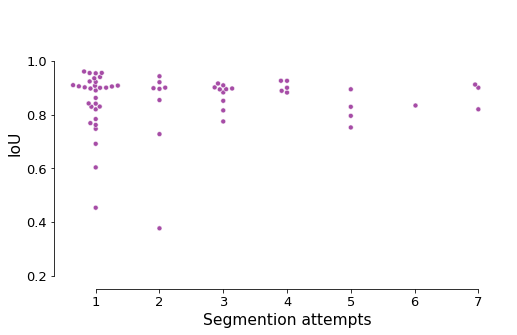

In [47]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(8, 5))


g = sns.swarmplot(
    y="iou", x="total_submissions",
    # palette=kromp_cmap,
    color="Purple",
    size=5,
    linewidth=0.8,
    edgecolor='white',
    alpha=.7,
    data=kromp_mask_df, ax=ax,
    # jitter=0.17
)

ax.set(ylabel="IoU")
ax.set(xlabel="Segmention attempts")

# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_ylim([0.19, 1.2])
# ax.set_xlim([0.9, 1000])

sns.despine(offset=10, trim=True)

plt.show()

In [4]:
# 'image_id': kromp_ids = set(['neurblas5', 'neurblas16', 'neurblas10', 'normal2', 'normal4'])

neurblas5_masks = masks_df.loc[masks_df['image_id'] == 'neurblas5', ['mask_arr', '']].values
neurblas10_masks = masks_df.loc[masks_df['image_id'] == 'neurblas10', 'mask_arr'].values
neurblas16_masks = masks_df.loc[masks_df['image_id'] == 'neurblas16', 'mask_arr'].values
normal2_masks = masks_df.loc[masks_df['image_id'] == 'normal2', 'mask_arr'].values
normal4_masks = masks_df.loc[masks_df['image_id'] == 'normal4', 'mask_arr'].values

In [5]:
neurblas5_masks = np.stack(neurblas5_masks, axis=0)
neurblas10_masks = np.stack(neurblas10_masks, axis=0)
neurblas16_masks = np.stack(neurblas16_masks, axis=0)
normal2_masks = np.stack(normal2_masks, axis=0)
normal4_masks = np.stack(normal4_masks, axis=0)

In [6]:
gt = np.load('kromp_gt.npz')

neurblas5_gt = gt['neurblas5']
neurblas10_gt = gt['neurblas10']
neurblas16_gt = gt['neurblas16']
normal2_gt = gt['normal2']
normal4_gt = gt['normal4']

In [7]:
def compute_iou_for_predictions(predictions, groundtruth):
    i = np.logical_and(predictions, groundtruth)
    u = np.logical_or(predictions, groundtruth)
    return np.sum(i) / np.sum(u)

In [8]:
neurblas5_iou = compute_iou_for_predictions(neurblas5_masks, neurblas5_gt)
neurblas10_iou = compute_iou_for_predictions(neurblas10_masks, neurblas10_gt)
neurblas16_iou = compute_iou_for_predictions(neurblas16_masks, neurblas16_gt)
normal2_iou = compute_iou_for_predictions(normal2_masks, normal2_gt)
normal4_iou = compute_iou_for_predictions(normal4_masks, normal4_gt)

In [9]:
# print(f"IoU for\n"
#       f"neurblas5:\t {neurblas5_iou}\n"
#       f"neurblas10:\t {neurblas10_iou}\n"
#       f"neurblas16:\t {neurblas16_iou}\n"
#       f"normal2:\t {normal2_iou}\n"
#       f"normal4:\t {normal4_iou}"
#       )

In [10]:
overview = {
    'image_id' : ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4'],
    'submitted_masks': [len(neurblas5_masks), len(neurblas10_masks), len(neurblas16_masks),len(normal2_masks), len(normal4_masks)],
    'mean_iou': [neurblas5_iou, neurblas10_iou, neurblas16_iou, normal2_iou, normal4_iou],
    'number_of_cells': [NUMBER_OF_CELLS['Neuroblastoma_5'], NUMBER_OF_CELLS['Neuroblastoma_10'], NUMBER_OF_CELLS['Neuroblastoma_16'], NUMBER_OF_CELLS['Normal_2'], NUMBER_OF_CELLS['Normal_4']],
}

overview_df = pd.DataFrame(data=overview)

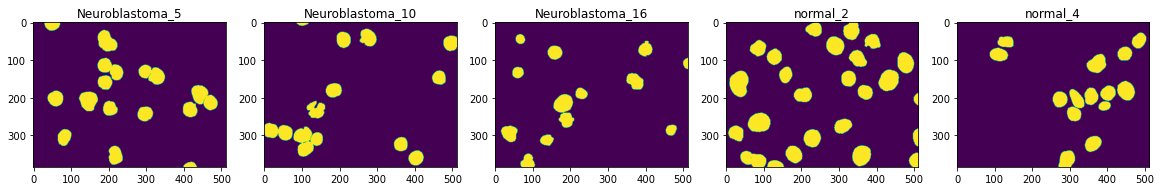

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

axs[0].set_title(f'Neuroblastoma_5')
axs[0].imshow(neurblas5_gt)

axs[1].set_title(f'Neuroblastoma_10')
axs[1].imshow(neurblas10_gt)

axs[2].set_title(f'Neuroblastoma_16')
axs[2].imshow(neurblas16_gt)

axs[3].set_title(f'normal_2')
axs[3].imshow(normal2_gt)

axs[4].set_title(f'normal_4')
axs[4].imshow(normal4_gt)

In [12]:
overview_df

,image_id,submitted_masks,mean_iou,number_of_cells
0,neurblas5,11,0.818907,18
1,neurblas10,10,0.836279,16
2,neurblas16,8,0.856618,16
3,normal2,12,0.815929,26
4,normal4,10,0.859991,15


In [13]:
#TODO boxplots for iou?
# plt.imshow(masks_df.loc[masks_df['id'] == '35175266-08d3-4fa9-b3eb-203d54b9f1bb', 'mask_arr'].values[0])